# Agent Metrics Analysis - Experiment 1

This notebook processes and visualizes eval metrics between average mode and no effect mode

In [44]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import os
import numpy as np
import seaborn as sns
import pickle

In [45]:
from __future__ import annotations

import glob
import os
import time
import csv

import supersuit as ss
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from scipy import stats as sci_stats

import gymnasium as gym 

from pettingzoo.sisl import waterworld_v4, waterworld_model1

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.evaluation import evaluate_policy
from pettingzoo.utils.conversions import aec_to_parallel
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement, CheckpointCallback

import numpy as np 
import pandas as pd

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor


## Set the log directory and process the data

In [46]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2, "haptic_modulation_type" : 'average'}


# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
log_dir = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240830-113028"
#myriad-no_effect_pettingzoo.sisl.waterworld_model1_20240830-113028/"
latest_policy = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240830-113028/best_model.zip"

model = RecurrentPPO.load(latest_policy)


In [47]:
obs = env.reset()

    # Cell and hidden state of the LSTM
lstm_states = None
num_envs = 1
    # Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)
num_games = 20 

In [48]:
print(f"Starting eval on {str(env.metadata['name'])}.")
# Initialize data structures to store step-wise information
all_data = []

for game in range(num_games):
    env.reset(seed=game+2026)
    print(f"Game {game}")
        
    game_data = {agent: {
            'rewards': [],
            'arousal': [],
            'satiety': [],
            'social-touch': [],
            'social-touch-modulation': [],
            'evader-eaten': [],
            'food_indicator': [],
            'nutrition-per-pursuer': [],
            'poison_indicator': [],
            'step': []
        } for agent in env.possible_agents}
        

    step = 0
    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()
            
            
        for a in env.agents:
            game_data[a]['rewards'].append(env.rewards[a])
            game_data[a]['step'].append(step)
                
            for metric in ['arousal', 'satiety', 'social-touch', 'social-touch-modulation', 
                               'evader-eaten', 'food_indicator', 'nutrition-per-pursuer', 'poison_indicator']:
                    if metric in info:
                        parts = info[metric].split('_')
                        agent_name = f"{parts[0]}_{parts[1]}"
                        if parts[2] == "initial":
                            value = 0
                        elif parts[2] == "True":
                            value = 1
                        elif parts[2] == "False":
                            value = 0
                        else:
                            try:
                                value = float(parts[2])
                            except ValueError:
                                print(f"Warning: Unexpected value '{parts[2]}' for {metric}. Setting to None.")
                                value = None
                        game_data[agent_name][metric].append(value)
                    else:
                        game_data[a][metric].append(None)  # or some default value

        if termination or truncation:
            break
        else:
            act = model.predict(obs, deterministic=True)[0]
            
        env.step(act)
        step += 1

    # Convert game data to DataFrame and add to all_data
    for agent, data in game_data.items():
        df = pd.DataFrame(data)
        df['agent'] = agent
        df['game'] = game
        all_data.append(df)

env.close()

# Combine all game data
df = pd.concat(all_data, ignore_index=True)


Starting eval on waterworld_model1.
Game 0
Game 1
Game 2
Game 3
Game 4
Game 5
Game 6
Game 7
Game 8
Game 9
Game 10
Game 11
Game 12
Game 13
Game 14
Game 15
Game 16
Game 17
Game 18
Game 19


In [54]:

def evaluate_model(model, env, num_games=20, seed_start=2026):
    print(f"Starting eval on {str(env.metadata['name'])}.")
    all_data = []

    for game in range(num_games):
        env.reset(seed=seed_start + game)
        print(f"Game {game}")
        game_data = {agent: {
            'rewards': [],
            'arousal': [],
            'satiety': [],
            'social-touch': [],
            'social-touch-modulation': [],
            'evader-eaten': [],
            'food_indicator': [],
            'nutrition-per-pursuer': [],
            'poison_indicator': [],
            'step': []
        } for agent in env.possible_agents}
        
        step = 0
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            for a in env.agents:
                game_data[a]['rewards'].append(env.rewards[a])
                game_data[a]['step'].append(step)
                for metric in ['arousal', 'satiety', 'social-touch', 'social-touch-modulation',
                               'evader-eaten', 'food_indicator', 'nutrition-per-pursuer', 'poison_indicator']:
                    if metric in info:
                        parts = info[metric].split('_')
                        agent_name = f"{parts[0]}_{parts[1]}"
                        if parts[2] == "initial":
                            value = 0
                        elif parts[2] == "True":
                            value = 1
                        elif parts[2] == "False":
                            value = 0
                        else:
                            try:
                                value = float(parts[2])
                            except ValueError:
                                print(f"Warning: Unexpected value '{parts[2]}' for {metric}. Setting to None.")
                                value = None
                        game_data[agent_name][metric].append(value)
                    else:
                        game_data[a][metric].append(None)  # or some default value
            
            if termination or truncation:
                break
            else:
                act = model.predict(obs, deterministic=True)[0]
                env.step(act)
            step += 1

        # Convert game data to DataFrame and add to all_data
        for agent, data in game_data.items():
            df = pd.DataFrame(data)
            df['agent'] = agent
            df['game'] = game
            all_data.append(df)

    env.close()
    
    # Combine all game data
    df = pd.concat(all_data, ignore_index=True)
    
    # Process the data to get one data point per game
    processed_df = process_game_data(df)
    
    return processed_df

def process_game_data(df):
    # Check if 'game' column exists
    if 'game' in df.columns:
        # Group by game and agent
        grouped = df.groupby(['game', 'agent'])
    else:
        # If 'game' doesn't exist, only group by agent
        grouped = df.groupby('agent')

    # List of metrics to aggregate
    metrics = {
        'rewards': 'sum',
        'satiety': 'mean',
        'arousal': 'mean',
        'social-touch': 'sum',
        'evader-eaten': 'sum',
        'food_indicator': 'sum',
        'poison_indicator': 'sum',
        'nutrition-per-pursuer': 'mean'
    }

    # Filter metrics based on what's available in the DataFrame
    available_metrics = {k: v for k, v in metrics.items() if k in df.columns}

    # Calculate metrics
    game_metrics = grouped.agg(available_metrics).reset_index()

    # Rename the 'rewards' column to 'cumulative_rewards' for clarity
    if 'rewards' in game_metrics.columns:
        game_metrics = game_metrics.rename(columns={'rewards': 'cumulative_rewards'})

    return game_metrics

In [50]:
def process_game_data(df):
    # Group by model, game, and agent
    grouped = df.groupby(['model', 'game', 'agent'])
    
    # Calculate metrics for each game
    game_metrics = grouped.agg({
        'rewards': 'sum',  # Cumulative rewards for the game
        'satiety': 'mean',  # Average satiety
        'arousal': 'mean',  # Average arousal
        'social-touch': 'sum'  # Number of touches
    }).reset_index()
    
    # Rename the 'rewards' column to 'cumulative_rewards' for clarity
    game_metrics = game_metrics.rename(columns={'rewards': 'cumulative_rewards'})
    
    return game_metrics


In [51]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2, "haptic_modulation_type" : 'average'}


# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240830-113028/best_model.zip"
#average_pettingzoo.sisl.waterworld_model1_20240824-101114/best_model.zip"
no_haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/myriad-no_effect_pettingzoo.sisl.waterworld_model1_20240830-113028/best_model.zip"
#no_effect_pettingzoo.sisl.waterworld_model1_20240824-101131/best_model.zip"
haptic_model = RecurrentPPO.load(haptic_mod_path)
no_haptic_model = RecurrentPPO.load(no_haptic_mod_path)

haptic_df = evaluate_model(haptic_model, env, num_games=20, seed_start=2026)


env_kwargs = {"n_pursuers" : 2, "haptic_modulation_type" : 'no_effect'}
env_fn = waterworld_model1
# Evaluate a trained agent vs a random agent
no_haptic_df = evaluate_model(no_haptic_model, env, num_games=20, seed_start=3026)


Starting eval on waterworld_model1.
Game 0
Game 1
Game 2
Game 3
Game 4
Game 5
Game 6
Game 7
Game 8
Game 9
Game 10
Game 11
Game 12
Game 13
Game 14
Game 15
Game 16
Game 17
Game 18
Game 19


KeyError: 'model'

In [ ]:
def save_dataframe_to_csv(df, filename):
    df.to_csv(filename, index=False)
    print(f"DataFrame saved to {filename}")

save_dataframe_to_csv(haptic_df, "haptic_model_on_haptic_env_evaln20.csv")
save_dataframe_to_csv(no_haptic_df, "no_haptic_model_on_no_haptic_env_evaln20.csv")

DataFrame saved to haptic_model_on_haptic_env_evaln20.csv
DataFrame saved to no_haptic_model_on_no_haptic_env_evaln20.csv


In [72]:
def compare_models_stats(df1, df2, metrics=['cumulative_rewards', 'satiety', 'arousal', 'evader-eaten',  'social-touch']):
    results = {}
    
    def average_agents(df):
        # Identify numeric columns, excluding 'game'
        numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_columns = [col for col in numeric_columns if col != 'game']
        
        # For numeric columns, calculate mean
        result = df.groupby('game')[numeric_columns].mean()
        
        # For non-numeric columns, take the first value (assuming they're the same for all agents)
        non_numeric_columns = [col for col in df.columns if col not in numeric_columns and col != 'game']
        if non_numeric_columns:
                result = result.join(df.groupby('game')[non_numeric_columns].first())
        
        return result.reset_index()

    # Average across agents for each game
    df1_avg = average_agents(df1)
    df2_avg = average_agents(df2)
    
    for metric in metrics:
        statistic, p_value = sci_stats.mannwhitneyu(df1_avg[metric], df2_avg[metric], alternative='two-sided')
        results[metric] = {
            'statistic': statistic,
            'p_value': p_value,
            'significant': p_value < 0.05
        }
    
    return results


In [73]:
comparison_results = compare_models_stats(haptic_df, no_haptic_df)

In [74]:
comparison_results

{'cumulative_rewards': {'statistic': 304.0,
  'p_value': 0.005115262023126529,
  'significant': True},
 'satiety': {'statistic': 303.0,
  'p_value': 0.0052973520767183885,
  'significant': True},
 'arousal': {'statistic': 126.0,
  'p_value': 0.045557802054804315,
  'significant': True},
 'evader-eaten': {'statistic': 297.5,
  'p_value': 0.0028179653093608845,
  'significant': True},
 'social-touch': {'statistic': 17.5,
  'p_value': 7.204576531571863e-07,
  'significant': True}}

Just analyse the rewards 

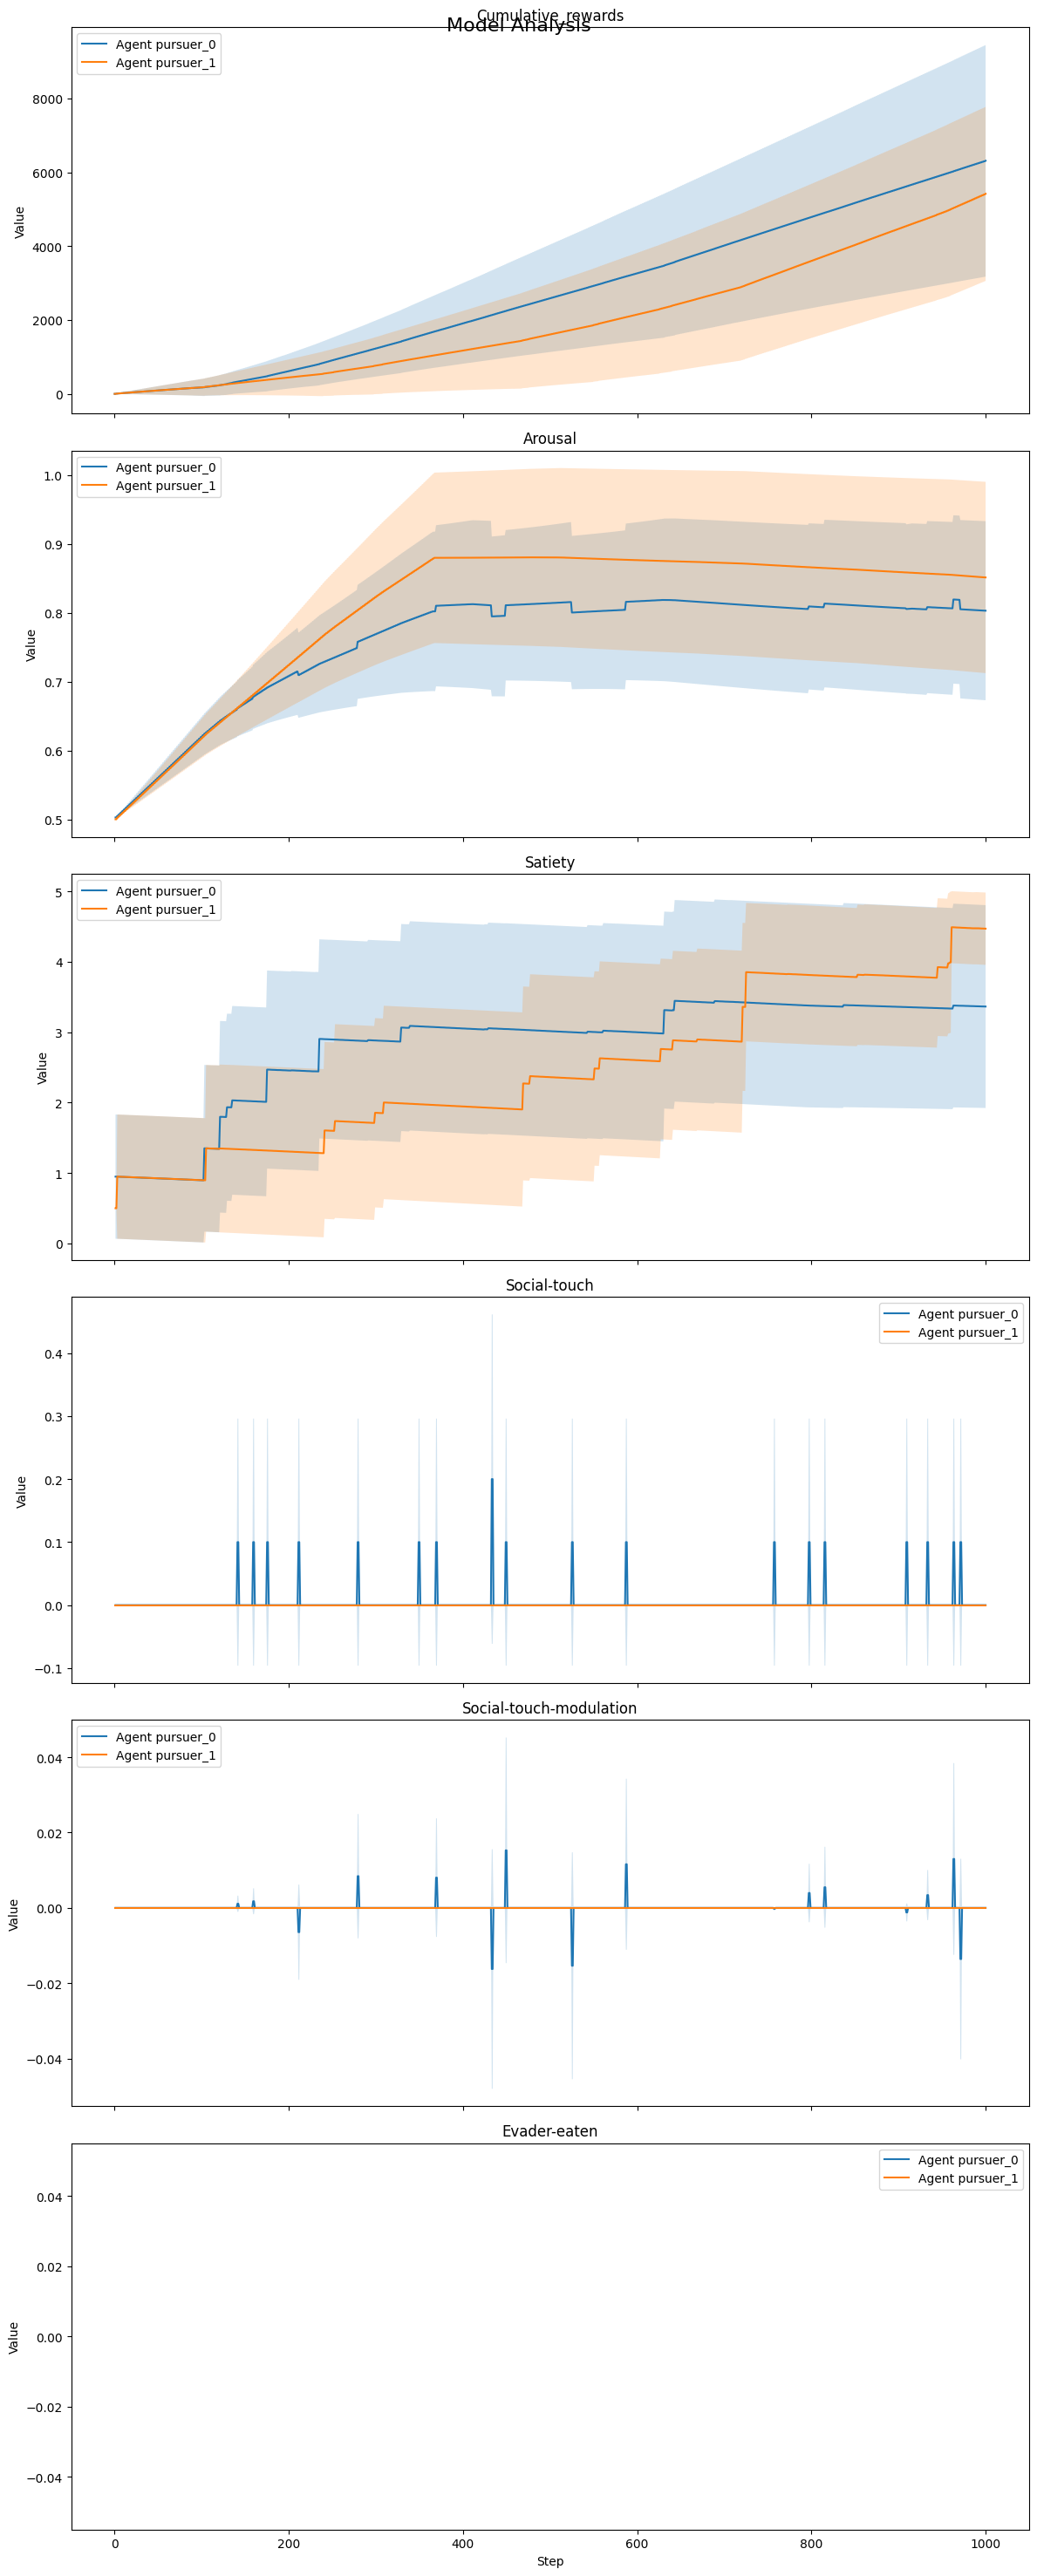


Cumulative Rewards Statistics per Game:

Agent pursuer_0:
  Mean: 6312.7863
  Median: 8930.5132
  Std Dev: 5061.1255
  Min: -442.0717
  Max: 12003.0907

Agent pursuer_1:
  Mean: 5419.1758
  Median: 4193.3018
  Std Dev: 3801.1622
  Min: 161.7427
  Max: 11757.4328


In [ ]:

# Function to calculate cumulative rewards
def calculate_cumulative_rewards(df):
    df['cumulative_rewards'] = df.groupby(['game', 'agent'])['rewards'].cumsum()
    return df
# Apply the function to the dataframe
df = calculate_cumulative_rewards(df)

# Determine which metrics to use based on the environment
if env.metadata['name'] == 'waterworld_v4':
    metrics = ['cumulative_rewards']
else:
    metrics = ['cumulative_rewards', 'arousal', 'satiety', 'social-touch', 'social-touch-modulation', 'evader-eaten']

# Convert 'evader-eaten' to 1 (True) and 0 (False) if it exists
if 'evader-eaten' in df.columns:
    df['evader-eaten'] = df['evader-eaten'].map({'True': 1, 'False': 0})

# Plotting
fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 5*len(metrics)), sharex=True)
fig.suptitle('Model Analysis', fontsize=16)

if len(metrics) == 1:
    axs = [axs]  # Make axs iterable when there's only one subplot

for i, metric in enumerate(metrics):
    axs[i].set_title(metric.capitalize())
    axs[i].set_ylabel('Value')
    for agent in df['agent'].unique():
        agent_data = df[df['agent'] == agent]
        mean_values = agent_data.groupby('step')[metric].mean()
        std_error = agent_data.groupby('step')[metric].sem()
        axs[i].plot(mean_values.index, mean_values.values, label=f'Agent {agent}')
        axs[i].fill_between(mean_values.index,
                            mean_values.values - 1.96*std_error.values,
                            mean_values.values + 1.96*std_error.values,
                            alpha=0.2)
    axs[i].legend()

axs[-1].set_xlabel('Step')
plt.tight_layout()
plt.show()

# Compute and display statistics for cumulative rewards in each game
print("\nCumulative Rewards Statistics per Game:")
for agent in df['agent'].unique():
    agent_data = df[df['agent'] == agent]
    final_rewards = agent_data.groupby('game')['cumulative_rewards'].last()
    print(f"\nAgent {agent}:")
    print(f"  Mean: {final_rewards.mean():.4f}")
    print(f"  Median: {final_rewards.median():.4f}")
    print(f"  Std Dev: {final_rewards.std():.4f}")
    print(f"  Min: {final_rewards.min():.4f}")
    print(f"  Max: {final_rewards.max():.4f}")


{'correlation': -0.03607198084133595, 'p_value': 0.9211951351979086, 'mean_touch_events': 4.8, 'std_touch_events': 2.573367875415838, 'mean_cumulative_reward': 6312.786267271758, 'std_cumulative_reward': 5061.125474222959}
Scatter plot saved to: touch_reward_correlation_no_agent1.png
Time series plot saved to: touch_events_over_time_no_agent1.png


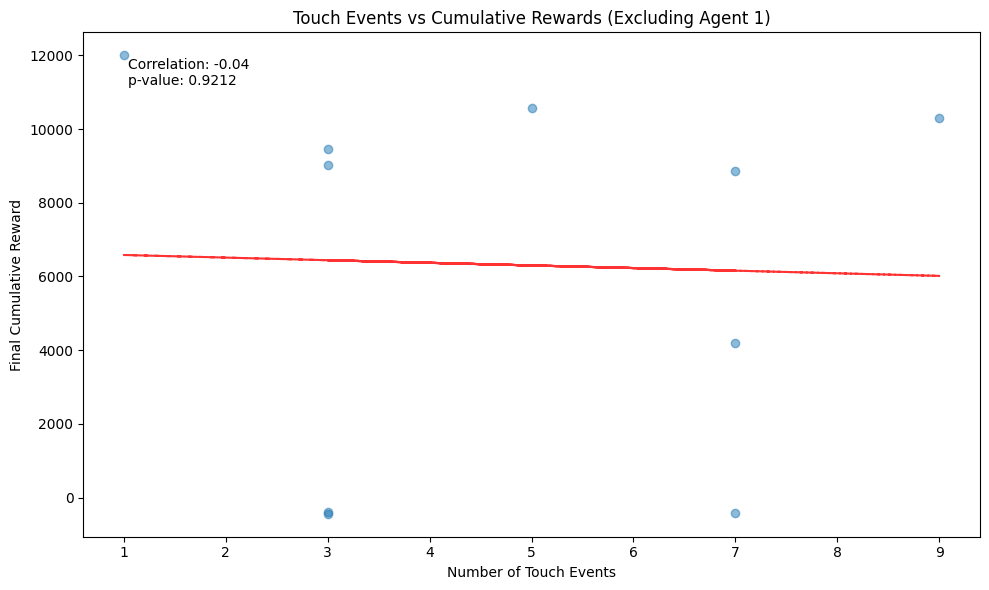

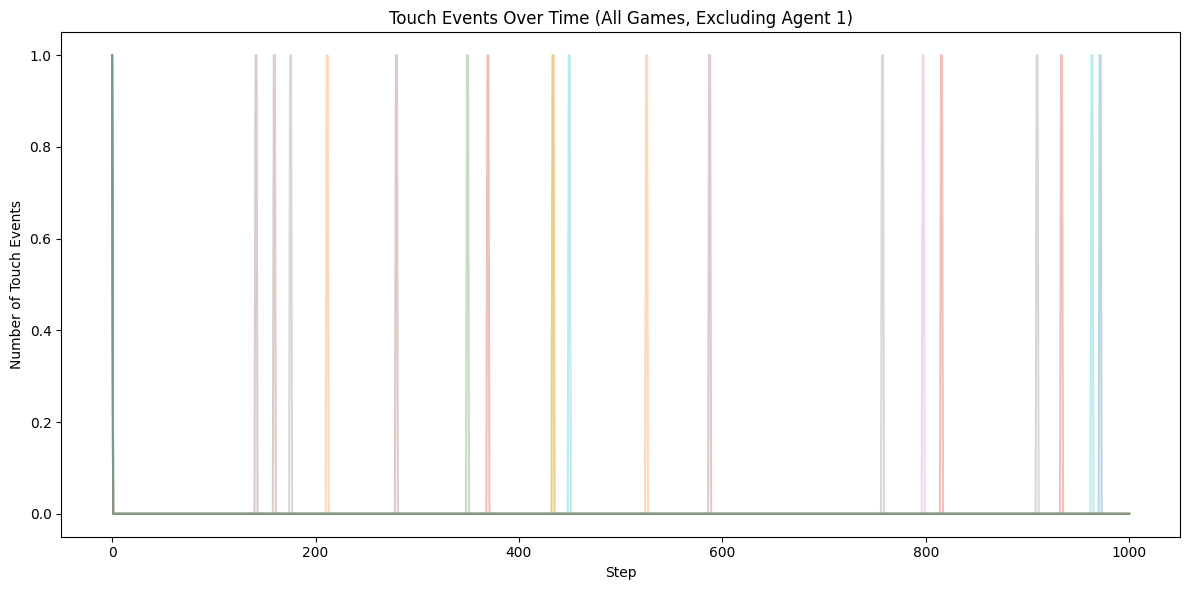

In [ ]:

def analyze_touch_reward_correlation(df):
    """
    Analyze the correlation between number of touch events and cumulative rewards per game,
    excluding agent 1.
    
    :param df: DataFrame containing the game data
    :return: Dictionary containing correlation results and plots
    """
    # Filter out agent 1
    df_filtered = df[df['agent'] != 'pursuer_1']

    # Group by game and agent, then calculate the total number of touch events and final cumulative reward
    game_summary = df_filtered.groupby(['game', 'agent']).agg({
        'social-touch': lambda x: x.ne(0).sum(),  # Count non-zero touch events
        'cumulative_rewards': 'last'  # Get the final cumulative reward
    }).reset_index()

    # Calculate the correlation
    correlation, p_value = sci_stats.pearsonr(game_summary['social-touch'], game_summary['cumulative_rewards'])

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(game_summary['social-touch'], game_summary['cumulative_rewards'], alpha=0.5)
    plt.xlabel('Number of Touch Events')
    plt.ylabel('Final Cumulative Reward')
    plt.title('Touch Events vs Cumulative Rewards (Excluding Agent 1)')
    
    # Add trend line
    z = np.polyfit(game_summary['social-touch'], game_summary['cumulative_rewards'], 1)
    p = np.poly1d(z)
    plt.plot(game_summary['social-touch'], p(game_summary['social-touch']), "r--", alpha=0.8)

    plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}\np-value: {p_value:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig('touch_reward_correlation_no_agent1.png')


    # Prepare summary statistics
    summary_stats = {
        'correlation': correlation,
        'p_value': p_value,
        'mean_touch_events': game_summary['social-touch'].mean(),
        'std_touch_events': game_summary['social-touch'].std(),
        'mean_cumulative_reward': game_summary['cumulative_rewards'].mean(),
        'std_cumulative_reward': game_summary['cumulative_rewards'].std()
    }

    # Additional analysis: Touch events over time
    time_series = df_filtered.groupby(['game', 'step']).agg({
        'social-touch': lambda x: x.ne(0).sum()
    }).reset_index()

    plt.figure(figsize=(12, 6))
    for game in time_series['game'].unique():
        game_data = time_series[time_series['game'] == game]
        plt.plot(game_data['step'], game_data['social-touch'], alpha=0.3)
    
    plt.xlabel('Step')
    plt.ylabel('Number of Touch Events')
    plt.title('Touch Events Over Time (All Games, Excluding Agent 1)')
    plt.tight_layout()
    plt.savefig('touch_events_over_time_no_agent1.png')
   

    return {
        'correlation_results': summary_stats,
        'scatter_plot_path': 'touch_reward_correlation_no_agent1.png',
        'time_series_plot_path': 'touch_events_over_time_no_agent1.png',
        'game_summary': game_summary
    }

# Example usage:
results = analyze_touch_reward_correlation(df)
print(results['correlation_results'])
print(f"Scatter plot saved to: {results['scatter_plot_path']}")
print(f"Time series plot saved to: {results['time_series_plot_path']}")

Print frequency of social touch and evader-eaten for every game and every agent

In [ ]:

print("\nFrequency of Social Touch and Evader-Eaten:")
for agent in df['agent'].unique():
    print(f"\nAgent {agent}:")
    agent_data = df[df['agent'] == agent]
    
    for episode in agent_data['game'].unique():
        episode_data = agent_data[agent_data['game'] == episode]
        
        social_touch_freq = episode_data['social-touch'].sum()
        evader_eaten_freq = episode_data['evader-eaten'].sum()
        
        print(f"  Episode {episode}:")
        print(f"    Social Touch Frequency: {social_touch_freq}")
        print(f"    Evader Eaten Frequency: {evader_eaten_freq}")



Frequency of Social Touch and Evader-Eaten:

Agent pursuer_0:
  Episode 0:
    Social Touch Frequency: 4.0
    Evader Eaten Frequency: 0.0
  Episode 1:
    Social Touch Frequency: 2.0
    Evader Eaten Frequency: 0.0
  Episode 2:
    Social Touch Frequency: 8.0
    Evader Eaten Frequency: 0.0
  Episode 3:
    Social Touch Frequency: 4.0
    Evader Eaten Frequency: 0.0
  Episode 4:
    Social Touch Frequency: 2.0
    Evader Eaten Frequency: 0.0
  Episode 5:
    Social Touch Frequency: 0.0
    Evader Eaten Frequency: 0.0
  Episode 6:
    Social Touch Frequency: 8.0
    Evader Eaten Frequency: 0.0
  Episode 7:
    Social Touch Frequency: 0.0
    Evader Eaten Frequency: 0.0
  Episode 8:
    Social Touch Frequency: 6.0
    Evader Eaten Frequency: 0.0
  Episode 9:
    Social Touch Frequency: 4.0
    Evader Eaten Frequency: 0.0

Agent pursuer_1:
  Episode 0:
    Social Touch Frequency: 0.0
    Evader Eaten Frequency: 0.0
  Episode 1:
    Social Touch Frequency: 0.0
    Evader Eaten Frequency:

In [ ]:
# Print overall evaluation results
print("\nOverall Evaluation Results:")
for agent in env.possible_agents:
    agent_data = df[df['agent'] == agent]
    print(f"Agent {agent}:")
    print(f" Total Reward: {agent_data['rewards'].sum():.4f}")
    
    # List of all metrics to analyze
    metrics = ['arousal', 'satiety', 'social-touch', 'social-touch-modulation', 'evader-eaten']
    
    for metric in metrics:
        if metric in agent_data.columns:

            # For 'evader-eaten', also show the percentage of True values
            if metric == 'evader-eaten':
                percentage_true = (agent_data[metric] == 1).mean() * 100
                print(f"   Percentage Eating = {percentage_true:.2f}%")
            else: 
                mean_value = agent_data[metric].mean()
                std_value = agent_data[metric].std()
                max_value = agent_data[metric].max()
                min_value = agent_data[metric].min()
                
                print(f" {metric.capitalize()}:")
                print(f"   Mean = {mean_value:.4f}")
                print(f"   Std  = {std_value:.4f}")
                print(f"   Max  = {max_value:.4f}")
                print(f"   Min  = {min_value:.4f}")
    
    print("\n")  # Add a blank line between agents for readability



Overall Evaluation Results:
Agent pursuer_0:
 Total Reward: 67656.4195
 Arousal:
   Mean = 0.7551
   Std  = 0.1837
   Max  = 0.9997
   Min  = 0.4513
 Satiety:
   Mean = 2.9740
   Std  = 2.1029
   Max  = 5.0000
   Min  = 0.0000
 Social-touch:
   Mean = 0.0038
   Std  = 0.0615
   Max  = 1.0000
   Min  = 0.0000
 Social-touch-modulation:
   Mean = 0.0001
   Std  = 0.0060
   Max  = 0.2017
   Min  = -0.1468
   Percentage Eating = 0.00%


Agent pursuer_1:
 Total Reward: 59575.8838
 Arousal:
   Mean = 0.7452
   Std  = 0.2115
   Max  = 0.9997
   Min  = 0.4101
 Satiety:
   Mean = 2.6548
   Std  = 2.2523
   Max  = 5.0000
   Min  = 0.0000
 Social-touch:
   Mean = 0.0000
   Std  = 0.0000
   Max  = 0.0000
   Min  = 0.0000
 Social-touch-modulation:
   Mean = 0.0000
   Std  = 0.0000
   Max  = 0.0000
   Min  = 0.0000
   Percentage Eating = 0.00%




PLOT RESULTS 

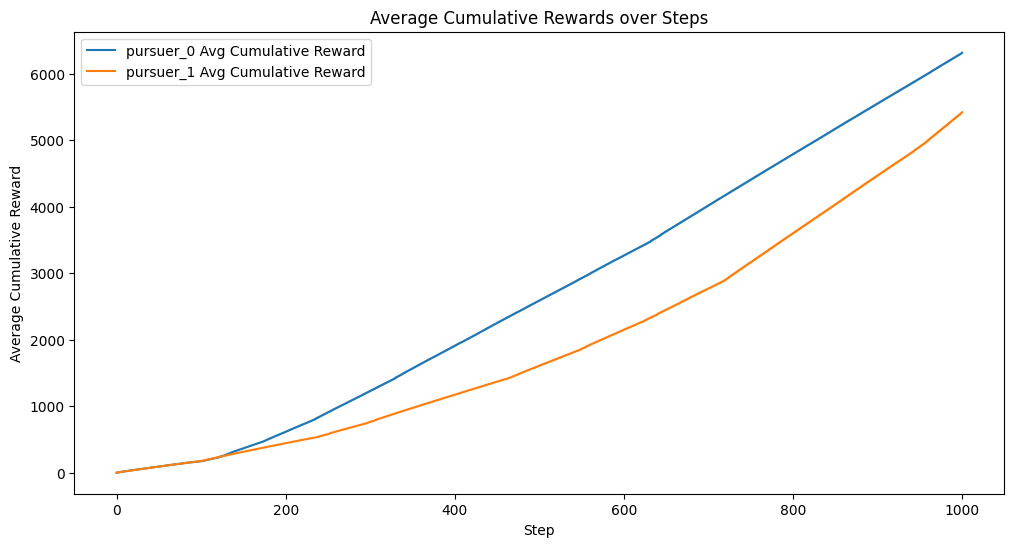

In [ ]:
# Create a directory for plots if it doesn't exist
plot_dir = log_dir
# Plot cumulative rewards
plt.figure(figsize=(12, 6))
for agent in df['agent'].unique():
    agent_data = df[df['agent'] == agent]
    cumulative_rewards = agent_data.groupby(['game', 'step'])['rewards'].sum().groupby('step').mean().cumsum()
    plt.plot(cumulative_rewards.index, cumulative_rewards.values, label=f'{agent} Avg Cumulative Reward')
plt.title('Average Cumulative Rewards over Steps')
plt.xlabel('Step')
plt.ylabel('Average Cumulative Reward')
plt.legend()
plt.savefig(f"{plot_dir}/avg_cumulative_rewards.png")

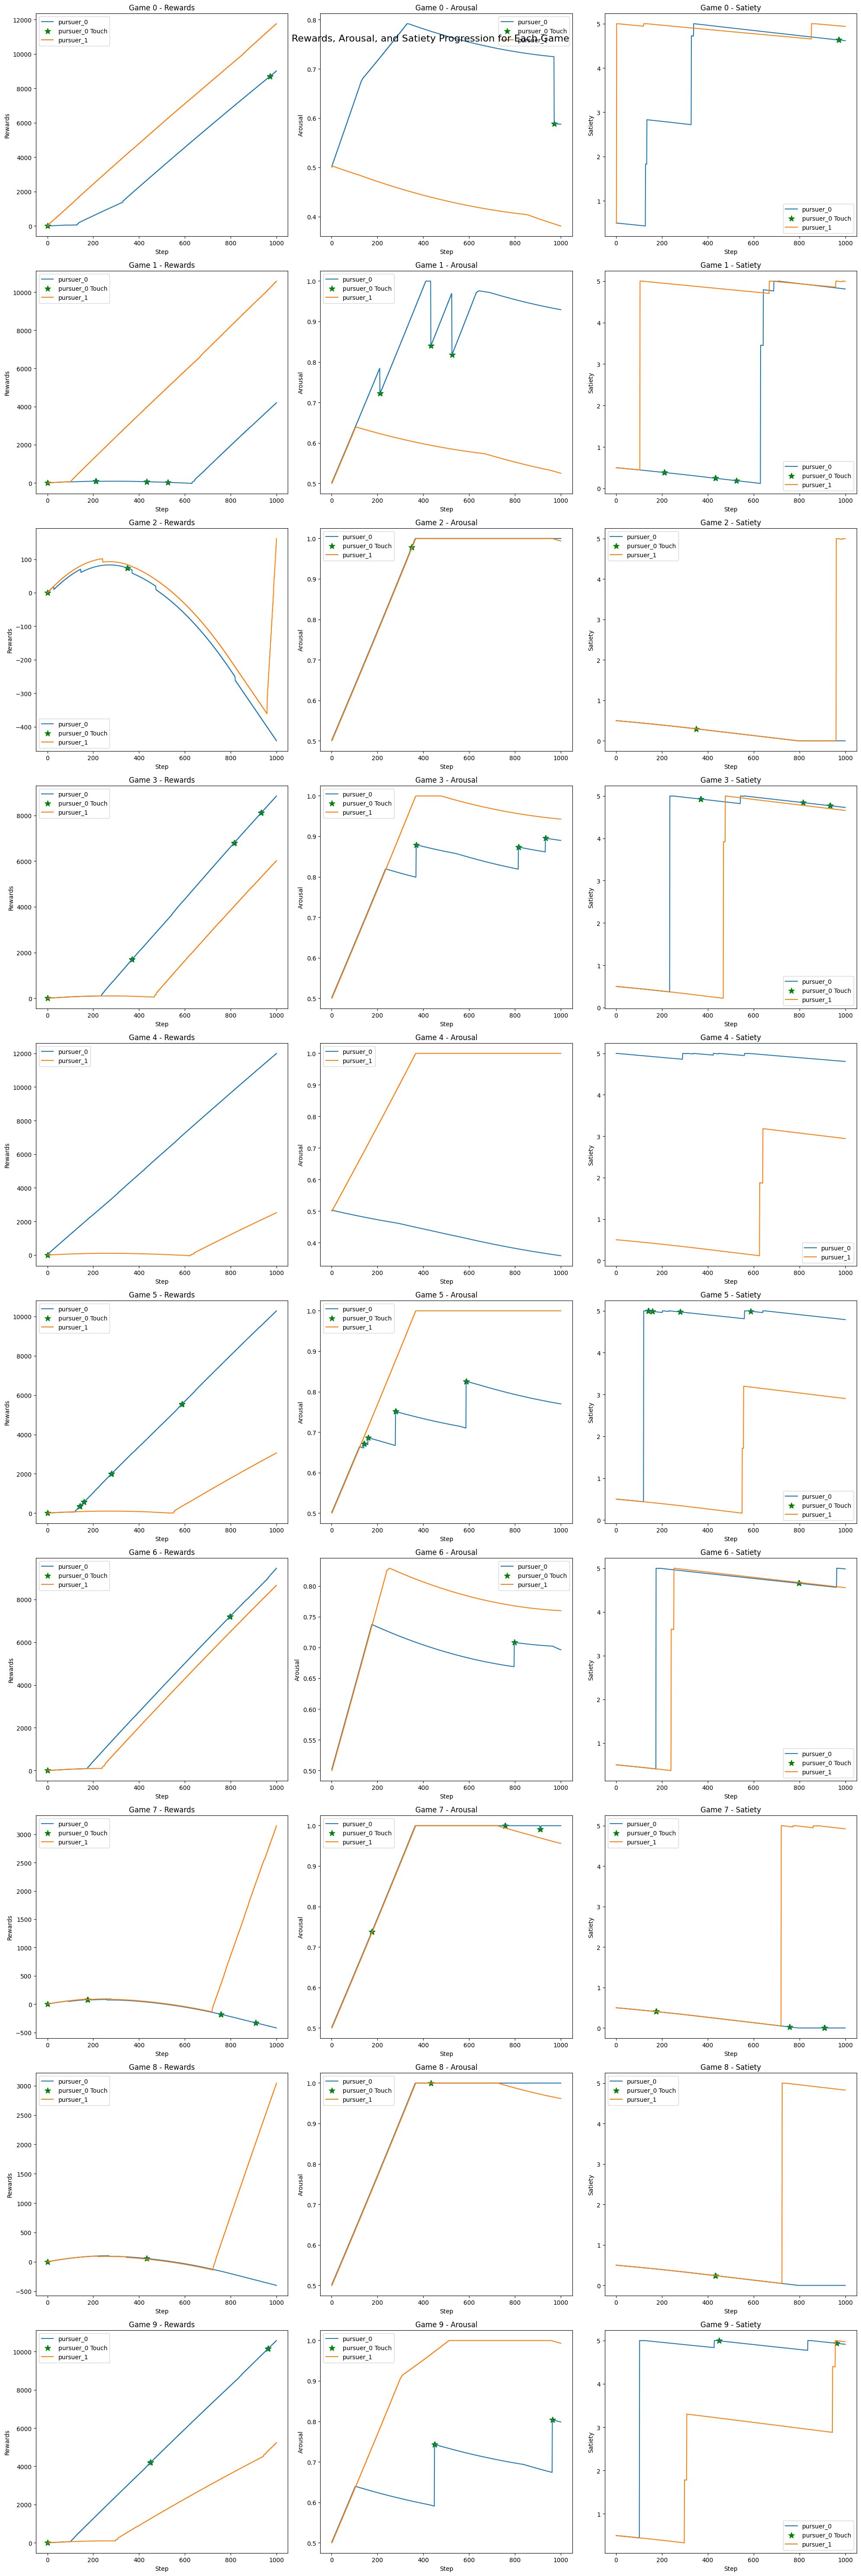

In [ ]:
 # Create comprehensive plot for rewards, arousal, and satiety for each game
num_games = df['game'].nunique()
fig, axes = plt.subplots(num_games, 3, figsize=(20, 6*num_games), squeeze=False)
fig.suptitle('Rewards, Arousal, and Satiety Progression for Each Game', fontsize=16)

metrics = ['rewards', 'arousal', 'satiety']
for game, ax_row in zip(sorted(df['game'].unique()), axes):
    game_data = df[df['game'] == game]
    
    for metric, ax in zip(metrics, ax_row):
        for agent in game_data['agent'].unique():
            agent_data = game_data[game_data['agent'] == agent]
            try:
                if metric == 'rewards':
                    values = agent_data[metric].astype(float).cumsum()
                else:
                    values = agent_data[metric].astype(float)
                
                # Plot the metric values
                ax.plot(agent_data['step'], values, label=agent)
                
                # Plot touch events as markers
                touch_events = agent_data[agent_data['social-touch'] != 0]['step']
                ax.scatter(touch_events, values.loc[touch_events.index], 
                            marker='*', s=100, c='green', label=f'{agent} Touch' if touch_events.any() else '')
                
            except (ValueError, TypeError) as e:
                print(f"Warning: Could not plot {metric} for agent {agent} in game {game}. Error: {str(e)}")
                continue
        
        ax.set_title(f'Game {game} - {metric.capitalize()}')
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.capitalize())
        ax.legend()

plt.tight_layout()
plt.savefig(f"{plot_dir}/comprehensive_game_metrics_with_touch_2.png")


{'absolute_correlation': -0.02133423428626379, 'absolute_p_value': 0.9288626530042724, 'relative_correlation': -0.05696492376215023, 'relative_p_value': 0.8114587774618796, 'mean_touch_events': 4.1, 'std_touch_events': 2.1980852911951394, 'mean_absolute_performance': 6596.087463921876, 'std_absolute_performance': 4909.2383600503135, 'mean_relative_performance': 498.5148595728356, 'std_relative_performance': 8000.451534932593}
Plot saved to: touch_performance_correlation.png


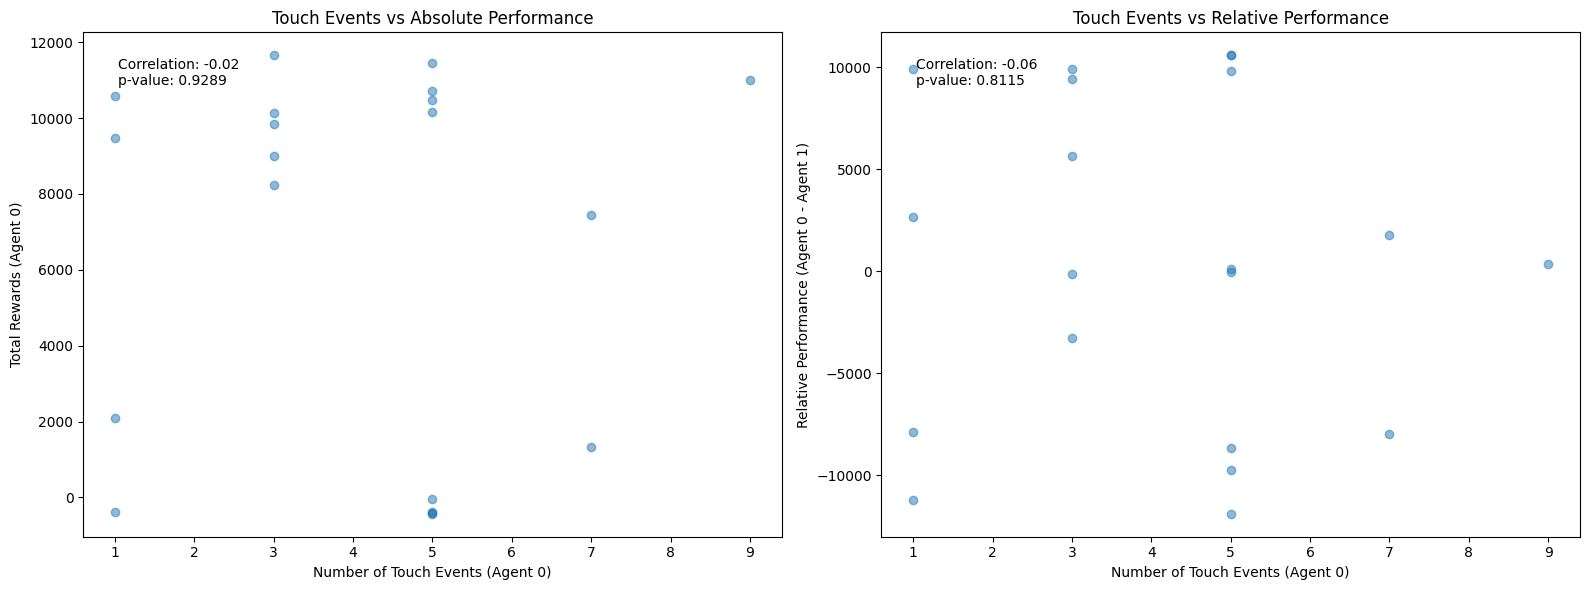

In [ ]:

def analyze_touch_reward_correlation(df):
    """
    Analyze the correlation between number of touch events for agent 0 and its performance,
    both absolute and relative to agent 1.
    
    :param df: DataFrame containing the game data
    :return: Dictionary containing correlation results and plots
    """
    # Prepare game summary
    game_summary = df.groupby(['game', 'agent']).agg({
        'social-touch': lambda x: x.ne(0).sum(),  # Count non-zero touch events
        'rewards': 'sum'  # Sum of rewards
    }).reset_index()

    # Pivot the data to have agents as columns
    game_summary_wide = game_summary.pivot(index='game', columns='agent', 
                                           values=['social-touch', 'rewards'])
    game_summary_wide.columns = [f'{col[1]}_{col[0]}' for col in game_summary_wide.columns]

    # Calculate relative performance
    game_summary_wide['relative_performance'] = game_summary_wide['pursuer_0_rewards'] - game_summary_wide['pursuer_1_rewards']

    # Prepare data for correlation analysis
    touch_events = game_summary_wide['pursuer_0_social-touch']
    absolute_performance = game_summary_wide['pursuer_0_rewards']
    relative_performance = game_summary_wide['relative_performance']

    # Calculate correlations
    corr_absolute, p_absolute = sci_stats.pearsonr(touch_events, absolute_performance)
    corr_relative, p_relative = sci_stats.pearsonr(touch_events, relative_performance)

    # Create scatter plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Absolute performance plot
    ax1.scatter(touch_events, absolute_performance, alpha=0.5)
    ax1.set_xlabel('Number of Touch Events (Agent 0)')
    ax1.set_ylabel('Total Rewards (Agent 0)')
    ax1.set_title('Touch Events vs Absolute Performance')
    ax1.text(0.05, 0.95, f'Correlation: {corr_absolute:.2f}\np-value: {p_absolute:.4f}', 
             transform=ax1.transAxes, verticalalignment='top')

    # Relative performance plot
    ax2.scatter(touch_events, relative_performance, alpha=0.5)
    ax2.set_xlabel('Number of Touch Events (Agent 0)')
    ax2.set_ylabel('Relative Performance (Agent 0 - Agent 1)')
    ax2.set_title('Touch Events vs Relative Performance')
    ax2.text(0.05, 0.95, f'Correlation: {corr_relative:.2f}\np-value: {p_relative:.4f}', 
             transform=ax2.transAxes, verticalalignment='top')

    plt.tight_layout()
    #plt.savefig('touch_performance_correlation.png')


    # Prepare summary statistics
    summary_stats = {
        'absolute_correlation': corr_absolute,
        'absolute_p_value': p_absolute,
        'relative_correlation': corr_relative,
        'relative_p_value': p_relative,
        'mean_touch_events': touch_events.mean(),
        'std_touch_events': touch_events.std(),
        'mean_absolute_performance': absolute_performance.mean(),
        'std_absolute_performance': absolute_performance.std(),
        'mean_relative_performance': relative_performance.mean(),
        'std_relative_performance': relative_performance.std()
    }

    return {
        'correlation_results': summary_stats,
        'plot_path': 'touch_performance_correlation.png',
        'game_summary': game_summary_wide
    }

# Example usage:
results = analyze_touch_reward_correlation(df)
print(results['correlation_results'])
print(f"Plot saved to: {results['plot_path']}")

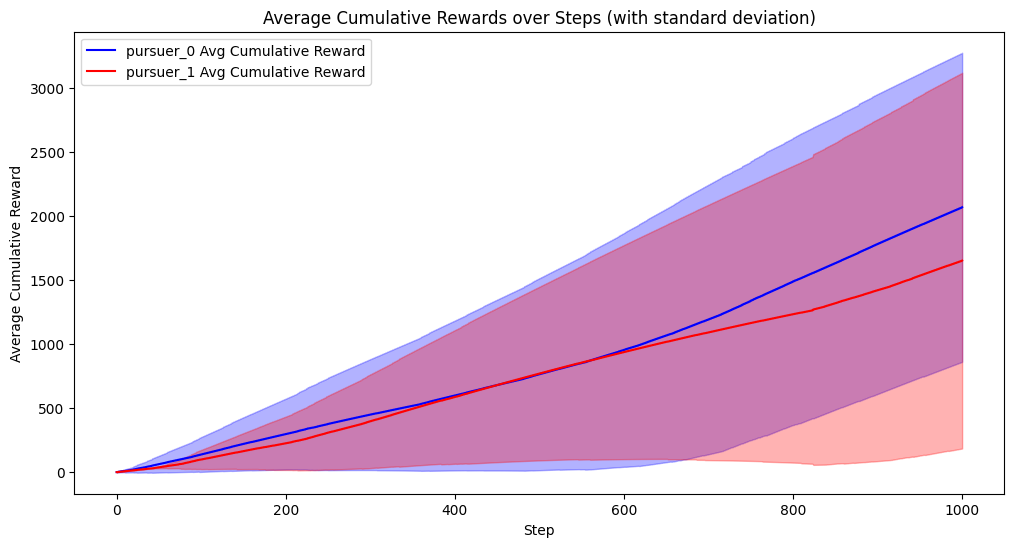

In [ ]:
# Plot average cumulative rewards with shaded areas
plt.figure(figsize=(12, 6))
colors = {'pursuer_0': 'blue', 'pursuer_1': 'red'}
for agent in df['agent'].unique():
    try:
        agent_data = df[df['agent'] == agent]
        grouped = agent_data.groupby(['game', 'step'])['rewards'].sum().astype(float).groupby('step')
        cumulative_rewards_mean = grouped.mean().cumsum()
        cumulative_rewards_std = grouped.std().cumsum()
        
        steps = cumulative_rewards_mean.index
        mean_values = cumulative_rewards_mean.values
        std_values = cumulative_rewards_std.values
        
        plt.plot(steps, mean_values, label=f'{agent} Avg Cumulative Reward', color=colors[agent])
        plt.fill_between(steps, 
                         mean_values - std_values, 
                         mean_values + std_values, 
                         alpha=0.3, 
                         color=colors[agent])
    except Exception as e:
        print(f"Warning: Could not plot average cumulative rewards for agent {agent}. Error: {str(e)}")
        continue

plt.title('Average Cumulative Rewards over Steps (with standard deviation)')
plt.xlabel('Step')
plt.ylabel('Average Cumulative Reward')
plt.legend()
plt.savefig(f"{plot_dir}/avg_cumulative_rewards_shaded.png")

/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc


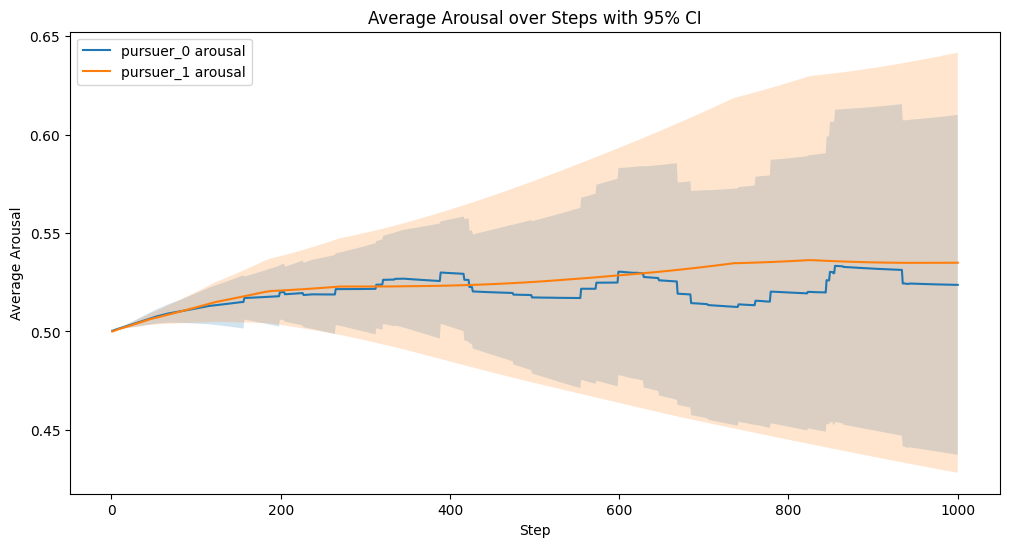

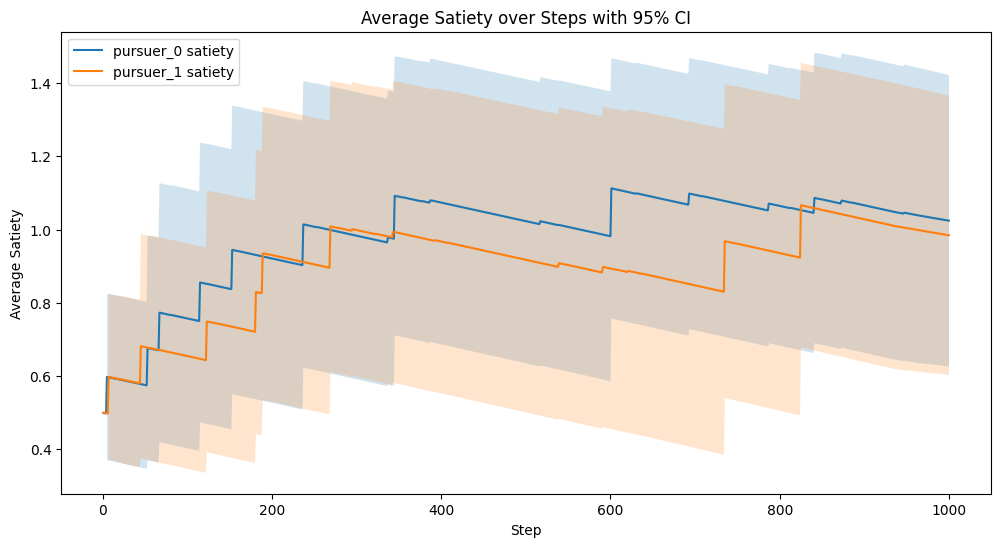

In [ ]:
# Plot average metrics with confidence intervals
for metric in metrics[1:]:
    plt.figure(figsize=(12, 6))
    for agent in df['agent'].unique():
        try:
            agent_data = df[df['agent'] == agent]
            numeric_data = agent_data[metric].astype(float)
            means = numeric_data.groupby(agent_data['step']).mean()
            
            def calculate_ci(x):
                try:
                    return stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x))
                except:
                    return (np.nan, np.nan)
            
            ci = numeric_data.groupby(agent_data['step']).agg(calculate_ci)
            ci_lower = [x[0] for x in ci]
            ci_upper = [x[1] for x in ci]
            
            plt.plot(means.index, means.values, label=f'{agent} {metric}')
            plt.fill_between(means.index, ci_lower, ci_upper, alpha=0.2)
        except Exception as e:
            print(f"Warning: Could not plot {metric} for agent {agent}. Error: {str(e)}")
            continue
    
    plt.title(f'Average {metric.capitalize()} over Steps with 95% CI')
    plt.xlabel('Step')
    plt.ylabel(f'Average {metric.capitalize()}')
    plt.legend()
    plt.savefig(f"{plot_dir}/{metric}_avg_with_ci.png")
    


Comparing two models in no haptic modulation environment and base waterworld environment 

In [ ]:

def compare_models(model1, model2, env, num_games=10, seed_start=138):
    def evaluate_model(model):
        obs = env.reset()

            # Cell and hidden state of the LSTM
        lstm_states = None
        num_envs = 1
            # Episode start signals are used to reset the lstm states
        episode_starts = np.ones((num_envs,), dtype=bool)
        num_games = 20

        all_data = []
        for game in range(num_games):
            env.reset(seed=seed_start+game)
            game_data = {agent: {
                'rewards': [], 'arousal': [], 'satiety': [], 
                'social-touch': [], 'evader-eaten': [], 'step': []
            } for agent in env.possible_agents}
            
            step = 0
            for agent in env.agent_iter():
                obs, reward, termination, truncation, info = env.last()
                
                for a in env.agents:
                    game_data[a]['rewards'].append(env.rewards[a])
                    game_data[a]['step'].append(step)
                    
                    for metric in ['arousal', 'satiety', 'social-touch', 'evader-eaten']:
                        if metric in info:
                            parts = info[metric].split('_')
                            agent_name = f"{parts[0]}_{parts[1]}"
                            value = float(parts[2]) if parts[2] not in ['initial', 'True', 'False'] else (0 if parts[2] in ['initial', 'False'] else 1)
                            game_data[agent_name][metric].append(value)
                        else:
                            game_data[a][metric].append(None)
                
                if termination or truncation:
                    break
                else:
                    act = model.predict(obs, deterministic=True)[0]
                env.step(act)
                step += 1
            
            for agent, data in game_data.items():
                df = pd.DataFrame(data)
                df['agent'] = agent
                df['game'] = game
                all_data.append(df)
        
        return pd.concat(all_data, ignore_index=True)

    df1 = evaluate_model(model1)
    df2 = evaluate_model(model2)

    # Determine which metrics to use based on the environment
    if env.metadata['name'] == 'waterworld_v4':
        metrics = ['rewards']
    else:
        metrics = ['rewards', 'arousal', 'satiety', 'social-touch', 'evader-eaten']

    # Convert 'evader-eaten' to 1 (True) and 0 (False) if it exists
    for df in [df1, df2]:
        if 'evader-eaten' in df.columns:
            df['evader-eaten'] = df['evader-eaten'].map({'True': 1, 'False': 0})

    # Plotting
    fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 5*len(metrics)), sharex=True)
    fig.suptitle('Model Comparison', fontsize=16)

    if len(metrics) == 1:
        axs = [axs]  # Make axs iterable when there's only one subplot

    for i, metric in enumerate(metrics):
        axs[i].set_title(metric.capitalize())
        axs[i].set_ylabel('Value')
        for model_num, df in enumerate([df1, df2], 1):
            mean_values = df.groupby('step')[metric].mean()
            std_error = df.groupby('step')[metric].sem()
            axs[i].plot(mean_values.index, mean_values.values, label=f'Model {model_num}')
            axs[i].fill_between(mean_values.index,
                                mean_values.values - 1.96*std_error.values,
                                mean_values.values + 1.96*std_error.values,
                                alpha=0.2)
        axs[i].legend()

    axs[-1].set_xlabel('Step')
    plt.tight_layout()
    plt.show()

    # Compute and display average and median performance
    print("\nPerformance Comparison:")
    for metric in metrics:
        print(f"\n{metric.capitalize()}:")
        for model_num, df in enumerate([df1, df2], 1):
            avg_performance = df[metric].mean()
            median_performance = df[metric].median()
            print(f"Model {model_num}:")
            print(f"  Average: {avg_performance:.4f}")
            print(f"  Median: {median_performance:.4f}")

    # Calculate and print correlation matrices
    print("\nCorrelation Matrices:")
    for model_num, df in enumerate([df1, df2], 1):
        print(f"\nModel {model_num}:")
        correlation_matrix = df[metrics].corr()
        print(correlation_matrix)
        
        # Visualize the correlation matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title(f"Correlation Matrix of Metrics - Model {model_num}")
        plt.tight_layout()
        plt.show()

    print("\nStatistical Tests:")
    for metric in metrics:
        print(f"\n{metric.capitalize()}:")
        t_stat, p_value = sci_stats.ttest_ind(df1[metric], df2[metric])
        print(f"Independent t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
        
        u_stat, p_value = sci_stats.mannwhitneyu(df1[metric], df2[metric])
        print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {p_value:.4f}")

        print("\nStatistical Comparison:")
        for metric in metrics:
            _, p_value = sci_stats.ttest_ind(df1[metric], df2[metric])
            print(f"{metric.capitalize()}:")
            print(f"  Model 1 mean: {df1[metric].mean():.4f}")
            print(f"  Model 2 mean: {df2[metric].mean():.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  {'Significant' if p_value < 0.05 else 'Not significant'} difference\n")

        social_touch_freq1 = (df1['social-touch'] > 0).mean()
        social_touch_freq2 = (df2['social-touch'] > 0).mean()
        print(f"Social Touch Frequency:")
        print(f"  Model 1: {social_touch_freq1:.4f}")
        print(f"  Model 2: {social_touch_freq2:.4f}")
    return df1, df2

# Usage:
# compare_models(model1, model2, env)

First: no haptic modulation

In [ ]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2, "haptic_modulation_type": "no_effect"}

# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240830-113028/best_model.zip"
#average_pettingzoo.sisl.waterworld_model1_20240824-101114/best_model.zip"
no_haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/myriad-no_effect_pettingzoo.sisl.waterworld_model1_20240830-113028/best_model.zip"
#no_effect_pettingzoo.sisl.waterworld_model1_20240824-101131/best_model.zip"

haptic_model = RecurrentPPO.load(haptic_mod_path)
no_haptic_model = RecurrentPPO.load(no_haptic_mod_path)

In [ ]:
df3 = evaluate_model(haptic_model, env, num_games=20, seed_start=3126)
df4 = evaluate_model(no_haptic_model, env, num_games=20, seed_start=3126)

Starting eval on waterworld_model1.
Game 0
Game 1
Game 2
Game 3
Game 4
Game 5
Game 6
Game 7
Game 8
Game 9
Game 10
Game 11
Game 12
Game 13
Game 14
Game 15
Game 16
Game 17
Game 18
Game 19
Starting eval on waterworld_model1.
Game 0
Game 1
Game 2
Game 3
Game 4
Game 5
Game 6
Game 7
Game 8
Game 9
Game 10
Game 11
Game 12
Game 13
Game 14
Game 15
Game 16
Game 17
Game 18
Game 19


In [ ]:
save_dataframe_to_csv(df3, "haptic_model_on_no_haptic_env_evaln20.csv")

DataFrame saved to haptic_model_on_no_haptic_env_evaln20.csv


In [75]:
no_haptic_comparison_results = compare_models_stats(df3, df4, metrics=['cumulative_rewards', 'satiety', 'arousal', 'evader-eaten', 'social-touch'])
print(no_haptic_comparison_results)

{'cumulative_rewards': {'statistic': 266.0, 'p_value': 0.07643094557954021, 'significant': False}, 'satiety': {'statistic': 260.5, 'p_value': 0.10189949001132276, 'significant': False}, 'arousal': {'statistic': 175.5, 'p_value': 0.5129278608239662, 'significant': False}, 'evader-eaten': {'statistic': 263.0, 'p_value': 0.041539102356861514, 'significant': True}, 'social-touch': {'statistic': 6.0, 'p_value': 1.1842720915474603e-07, 'significant': True}}


In [76]:
compare_models(haptic_model, no_haptic_model, env)

TypeError: 'OrderEnforcingWrapper' object is not iterable

In [ ]:
# Set your log directory here
env_fn = waterworld_v4
env_kwargs = {"n_pursuers" : 2}

# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/average_pettingzoo.sisl.waterworld_model1_20240824-101114/best_model.zip"
no_haptic_mod_path = "/Users/idil/PettingZoo/SB3-training/logs/no_effect_pettingzoo.sisl.waterworld_model1_20240824-101131/best_model.zip"

haptic_model = RecurrentPPO.load(haptic_mod_path)
no_haptic_model = RecurrentPPO.load(no_haptic_mod_path)

In [ ]:
df5 = evaluate_model(haptic_model, env, num_games=20, seed_start=4126)
df6 = evaluate_model(no_haptic_model, env, num_games=20, seed_start=4226)

Starting eval on waterworld_v4.
Game 0
Game 1
Game 2
Game 3
Game 4
Game 5
Game 6
Game 7
Game 8
Game 9
Game 10
Game 11
Game 12
Game 13
Game 14
Game 15
Game 16
Game 17
Game 18
Game 19
Starting eval on waterworld_v4.
Game 0
Game 1
Game 2
Game 3
Game 4
Game 5
Game 6
Game 7
Game 8
Game 9
Game 10
Game 11
Game 12
Game 13
Game 14
Game 15
Game 16
Game 17
Game 18
Game 19


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [77]:
waterworld_comparison_results = compare_models_stats(df5, df6, metrics=['cumulative_rewards'])

In [78]:
waterworld_comparison_results

{'cumulative_rewards': {'statistic': 82.0,
  'p_value': 0.0014809771857968636,
  'significant': True}}

Comparing the social touch game with original waterworld game performance 

In [52]:
# Set your log directory here
env_fn = waterworld_v4
env_kwargs = {"n_pursuers" : 2}

# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
original_waterworld_path = "/Users/idil/PettingZoo/SB3-training/logs/myriad-no_haptic_pettingzoo.sisl.waterworld_v4_20240902-143121/best_model.zip"

orig_model = RecurrentPPO.load(original_waterworld_path)

In [55]:
orig_df = evaluate_model(orig_model, env, num_games=20, seed_start=4126)


Starting eval on waterworld_v4.
Game 0
Game 1
Game 2
Game 3
Game 4
Game 5
Game 6
Game 7
Game 8
Game 9
Game 10
Game 11
Game 12
Game 13
Game 14
Game 15
Game 16
Game 17
Game 18
Game 19


In [83]:
haptic_in_waterworld_df = evaluate_model(haptic_model, env, num_games=20, seed_start=5126)

Starting eval on waterworld_v4.
Game 0
Game 1
Game 2
Game 3
Game 4
Game 5
Game 6
Game 7
Game 8
Game 9
Game 10
Game 11
Game 12
Game 13
Game 14
Game 15
Game 16
Game 17
Game 18
Game 19


In [79]:
orig_to_touch_comparison = compare_models_stats(haptic_df, orig_df, metrics=['cumulative_rewards'])
print(orig_to_touch_comparison)

{'cumulative_rewards': {'statistic': 380.0, 'p_value': 1.2008881938423432e-06, 'significant': True}}


In [81]:
np.median(average_agents(haptic_df)['cumulative_rewards'])

6376.983493954148

In [82]:
np.median(average_agents(orig_df)['cumulative_rewards'])

45.79210548019986

In [84]:
orig_to_touch_waterworld_comparison = compare_models_stats(haptic_in_waterworld_df, orig_df, metrics=['cumulative_rewards'])
print(orig_to_touch_waterworld_comparison)

{'cumulative_rewards': {'statistic': 150.0, 'p_value': 0.1805773768084653, 'significant': False}}


In [86]:
save_dataframe_to_csv(orig_df, "original_in_waterworld_eval20.csv")
save_dataframe_to_csv(haptic_in_waterworld_df, "haptic_in_waterworld_eval20.csv")

DataFrame saved to original_in_waterworld_eval20.csv
DataFrame saved to haptic_in_waterworld_eval20.csv


Investigating different starting states:

scenario 1: 
pursuer 0
initial_satiety=0.5,
initial_arousal=0.9, 
pursuer 1 
initial_satiety=0.5,
initial_arousal=0.1,


scenario 2: 
pursuer 0: 
initial_satiety=0.1,
initial_arousal=0.5,
Pursuer 1:
initial_satiety=0.9,
initial_arousal=0.5,


In [12]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2, "haptic_modulation_type" : 'no_effect'}


# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
log_dir = "/Users/idil/PettingZoo/SB3-training/logs/myriad-no_effect_pettingzoo.sisl.waterworld_model1_20240830-113028/"
latest_policy = "/Users/idil/PettingZoo/SB3-training/logs/myriad-no_effect_pettingzoo.sisl.waterworld_model1_20240830-113028/best_model.zip"

model = RecurrentPPO.load(latest_policy)

obs = env.reset()

    # Cell and hidden state of the LSTM
lstm_states = None
num_envs = 1
    # Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)
num_games = 10 

print(f"Starting eval on {str(env.metadata['name'])}.")
# Initialize data structures to store step-wise information
all_data = []

for game in range(num_games):
    env.reset(seed=game+5180)
    print(f"Game {game}")
        
    game_data = {agent: {
            'rewards': [],
            'arousal': [],
            'satiety': [],
            'social-touch': [],
            'social-touch-modulation': [],
            'evader-eaten': [],
            'food_indicator': [],
            'nutrition-per-pursuer': [],
            'poison_indicator': [],
            'step': []
        } for agent in env.possible_agents}
        

    step = 0
    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()
            
            
        for a in env.agents:
            game_data[a]['rewards'].append(env.rewards[a])
            game_data[a]['step'].append(step)
                
            for metric in ['arousal', 'satiety', 'social-touch', 'social-touch-modulation', 
                               'evader-eaten', 'food_indicator', 'nutrition-per-pursuer', 'poison_indicator']:
                    if metric in info:
                        parts = info[metric].split('_')
                        agent_name = f"{parts[0]}_{parts[1]}"
                        if parts[2] == "initial":
                            value = 0
                        elif parts[2] == "True":
                            value = 1
                            print("here eaten")
                        elif parts[2] == "False":
                            value = 0
                        else:
                            try:
                                value = float(parts[2])
                            except ValueError:
                                print(f"Warning: Unexpected value '{parts[2]}' for {metric}. Setting to None.")
                                value = None
                        game_data[agent_name][metric].append(value)
                    else:
                        game_data[a][metric].append(None)  # or some default value

        if termination or truncation:
            break
        else:
            act = model.predict(obs, deterministic=True)[0]
            
        env.step(act)
        step += 1

    # Convert game data to DataFrame and add to all_data
    for agent, data in game_data.items():
        df = pd.DataFrame(data)
        df['agent'] = agent
        df['game'] = game
        all_data.append(df)

env.close()

# Combine all game data
df = pd.concat(all_data, ignore_index=True)


Starting eval on waterworld_model1.
Game 0
Game 1
Game 2
Game 3
Game 4
here eaten
here eaten
here eaten
here eaten
Game 5
here eaten
here eaten
here eaten
here eaten
Game 6
Game 7
Game 8
Game 9


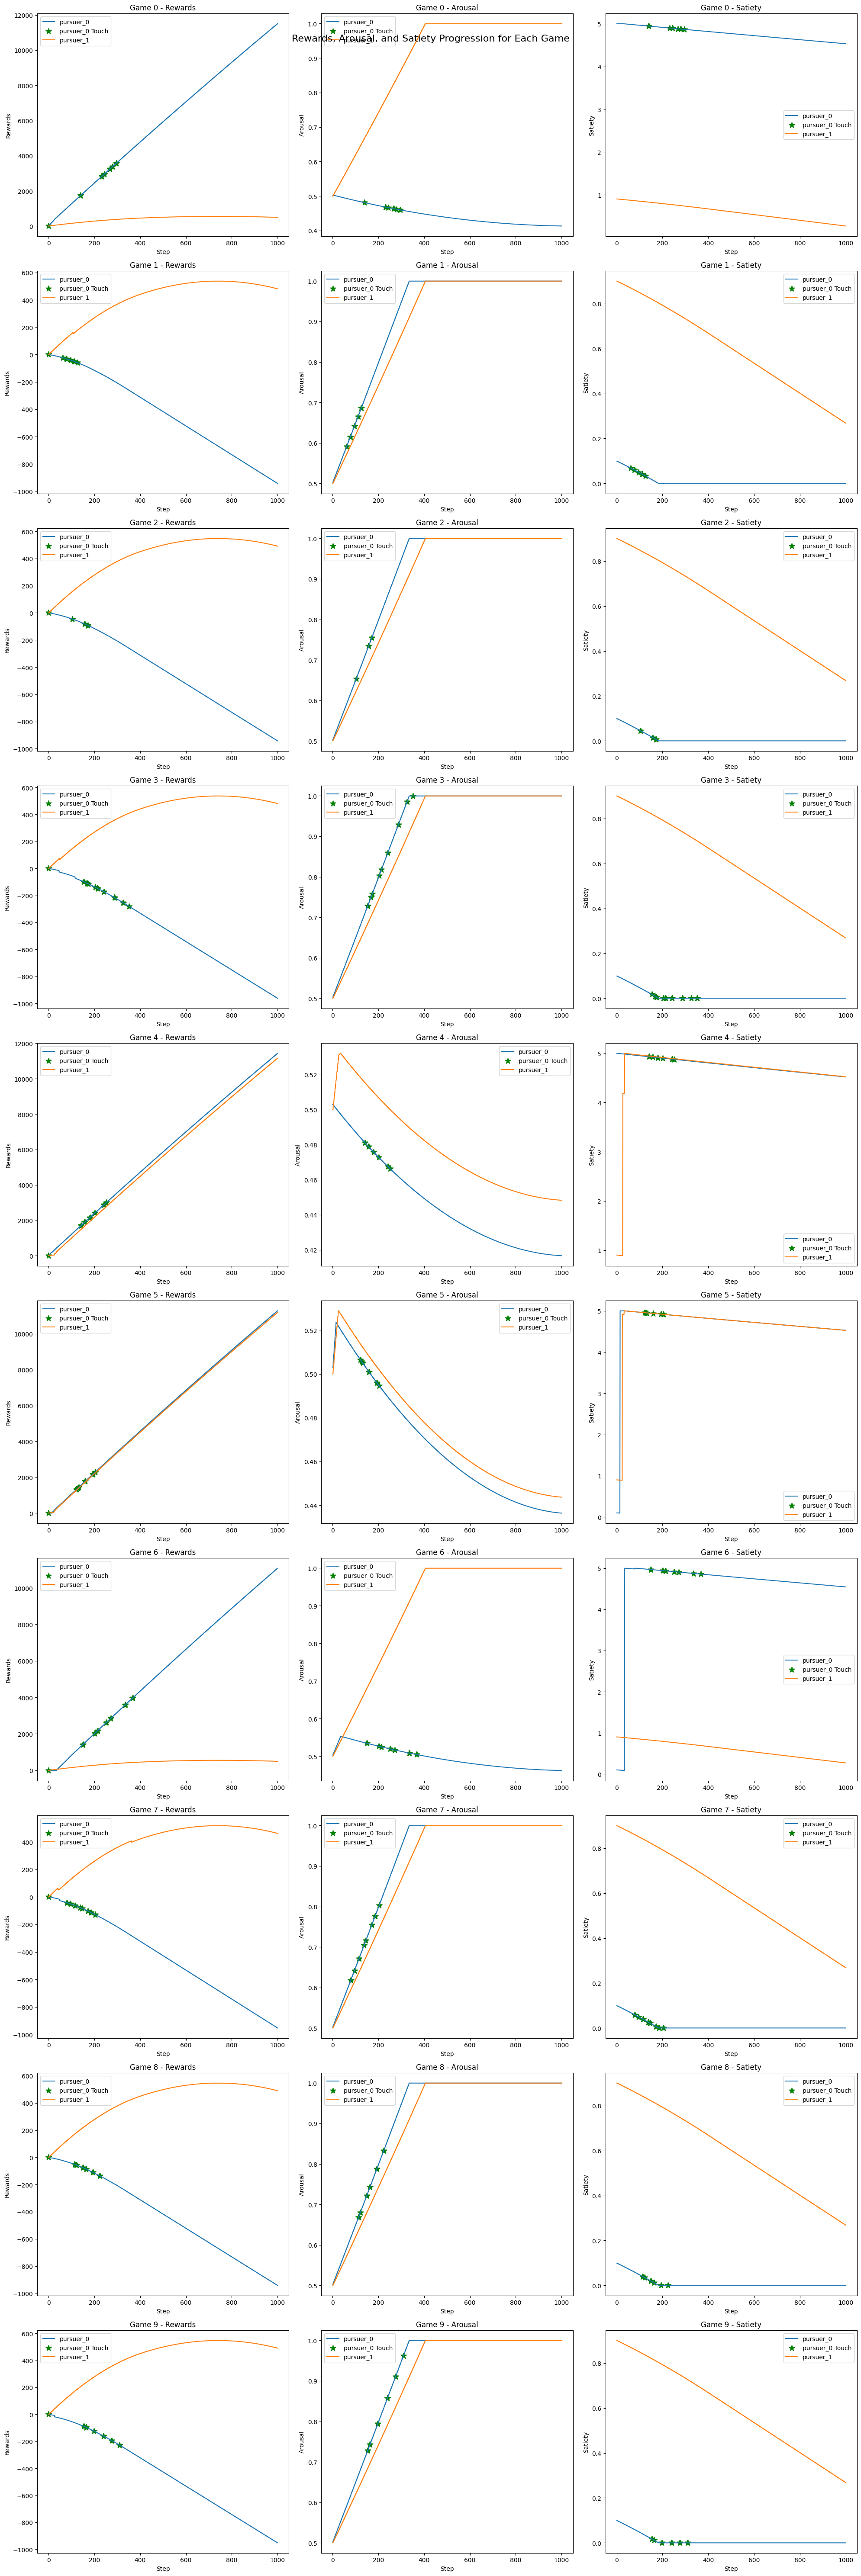

In [13]:
 # Create comprehensive plot for rewards, arousal, and satiety for each game
num_games = df['game'].nunique()
fig, axes = plt.subplots(num_games, 3, figsize=(20, 6*num_games), squeeze=False)
fig.suptitle('Rewards, Arousal, and Satiety Progression for Each Game', fontsize=16)

metrics = ['rewards', 'arousal', 'satiety']
for game, ax_row in zip(sorted(df['game'].unique()), axes):
    game_data = df[df['game'] == game]
    
    for metric, ax in zip(metrics, ax_row):
        for agent in game_data['agent'].unique():
            agent_data = game_data[game_data['agent'] == agent]
            try:
                if metric == 'rewards':
                    values = agent_data[metric].astype(float).cumsum()
                else:
                    values = agent_data[metric].astype(float)
                
                # Plot the metric values
                ax.plot(agent_data['step'], values, label=agent)
                
                # Plot touch events as markers
                touch_events = agent_data[agent_data['social-touch'] != 0]['step']
                ax.scatter(touch_events, values.loc[touch_events.index], 
                            marker='*', s=100, c='green', label=f'{agent} Touch' if touch_events.any() else '')
                
            except (ValueError, TypeError) as e:
                print(f"Warning: Could not plot {metric} for agent {agent} in game {game}. Error: {str(e)}")
                continue
        
        ax.set_title(f'Game {game} - {metric.capitalize()}')
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.capitalize())
        ax.legend()

plt.tight_layout()



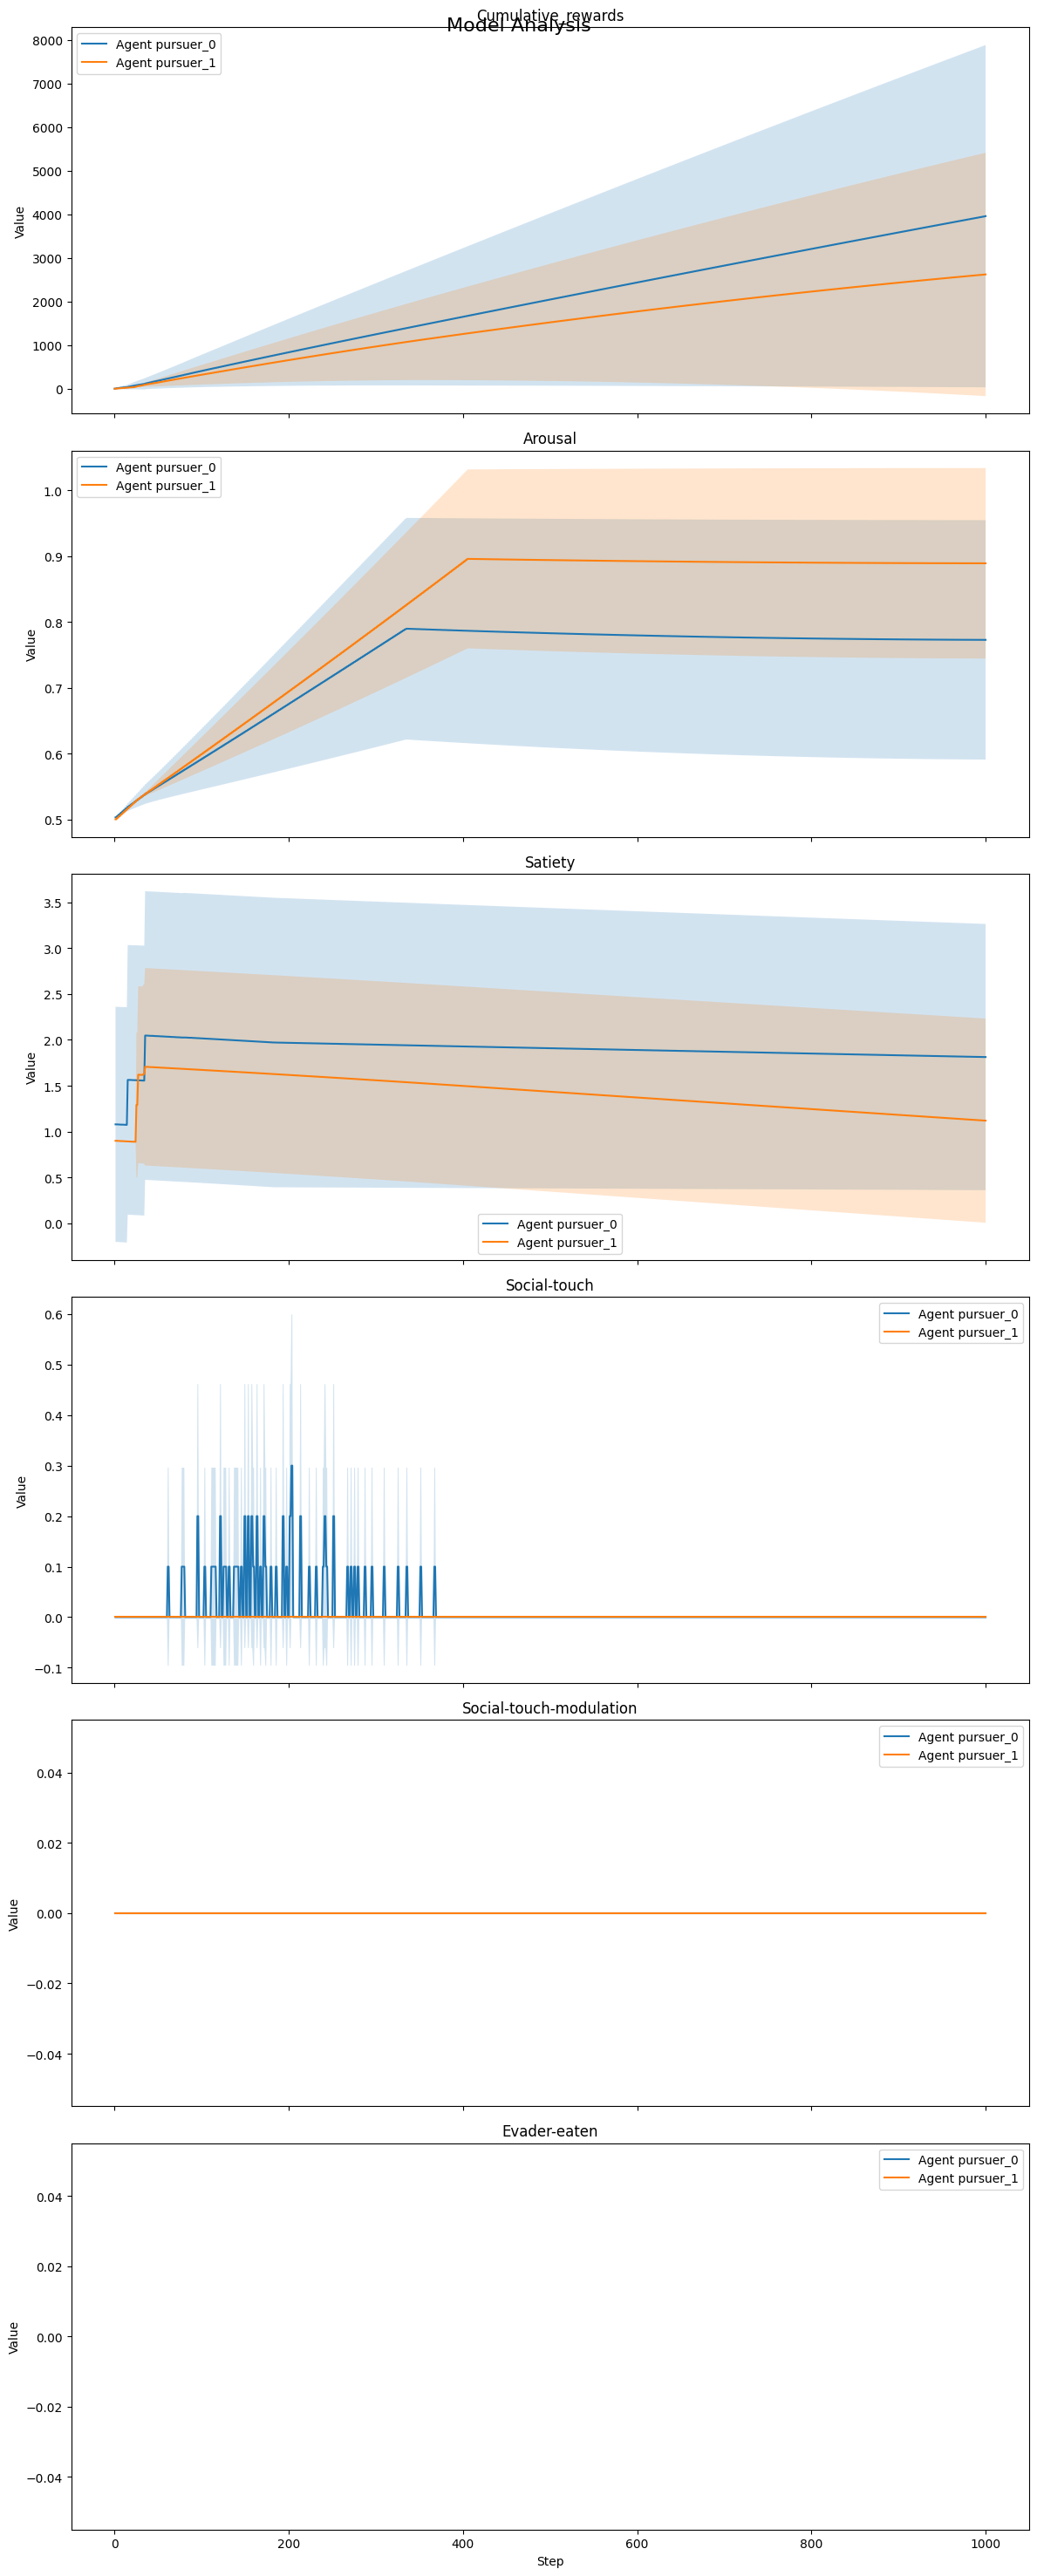


Cumulative Rewards Statistics per Game:

Agent pursuer_0:
  Mean: 3960.1618
  Median: -942.4977
  Std Dev: 6338.7955
  Min: -962.3403
  Max: 11508.0013

Agent pursuer_1:
  Mean: 2622.3924
  Median: 490.5936
  Std Dev: 4506.5667
  Min: 461.0759
  Max: 11187.5303


In [14]:

# Function to calculate cumulative rewards
def calculate_cumulative_rewards(df):
    df['cumulative_rewards'] = df.groupby(['game', 'agent'])['rewards'].cumsum()
    return df
# Apply the function to the dataframe
df = calculate_cumulative_rewards(df)

# Determine which metrics to use based on the environment
if env.metadata['name'] == 'waterworld_v4':
    metrics = ['cumulative_rewards']
else:
    metrics = ['cumulative_rewards', 'arousal', 'satiety', 'social-touch', 'social-touch-modulation', 'evader-eaten']

# Convert 'evader-eaten' to 1 (True) and 0 (False) if it exists
if 'evader-eaten' in df.columns:
    df['evader-eaten'] = df['evader-eaten'].map({'True': 1, 'False': 0})

# Plotting
fig, axs = plt.subplots(len(metrics), 1,  figsize=(12, 5*len(metrics)), sharex=True)
fig.suptitle('Model Analysis', fontsize=16)

if len(metrics) == 1:
    axs = [axs]  # Make axs iterable when there's only one subplot

for i, metric in enumerate(metrics):
    axs[i].set_title(metric.capitalize())
    axs[i].set_ylabel('Value')
    for agent in df['agent'].unique():
        agent_data = df[df['agent'] == agent]
        mean_values = agent_data.groupby('step')[metric].mean()
        std_error = agent_data.groupby('step')[metric].sem()
        axs[i].plot(mean_values.index, mean_values.values, label=f'Agent {agent}')
        axs[i].fill_between(mean_values.index,
                            mean_values.values - 1.96*std_error.values,
                            mean_values.values + 1.96*std_error.values,
                            alpha=0.2)
    axs[i].legend()

axs[-1].set_xlabel('Step')
plt.tight_layout()
plt.show()

# Compute and display statistics for cumulative rewards in each game
print("\nCumulative Rewards Statistics per Game:")
for agent in df['agent'].unique():
    agent_data = df[df['agent'] == agent]
    final_rewards = agent_data.groupby('game')['cumulative_rewards'].last()
    print(f"\nAgent {agent}:")
    print(f"  Mean: {final_rewards.mean():.4f}")
    print(f"  Median: {final_rewards.median():.4f}")
    print(f"  Std Dev: {final_rewards.std():.4f}")
    print(f"  Min: {final_rewards.min():.4f}")
    print(f"  Max: {final_rewards.max():.4f}")

Compare environments for different satiety states 

In [16]:

def compare_environments(model, env1, env2, num_games=20, seed_start=114338):
    def evaluate_env(env, seed_offset=0):
        obs = env.reset()

        # Cell and hidden state of the LSTM
        lstm_states = None
        num_envs = 1
        # Episode start signals are used to reset the lstm states
        episode_starts = np.ones((num_envs,), dtype=bool)

        all_data = []
        for game in range(num_games):
            env.reset(seed=seed_start + seed_offset + game)
            game_data = {agent: {
                'rewards': [], 'arousal': [], 'satiety': [], 
                'social-touch': [], 'evader-eaten': [], 'step': []
            } for agent in env.possible_agents}

            step = 0
            for agent in env.agent_iter():
                obs, reward, termination, truncation, info = env.last()

                for a in env.agents:
                    game_data[a]['rewards'].append(env.rewards[a])
                    game_data[a]['step'].append(step)

                    for metric in ['arousal', 'satiety', 'social-touch', 'evader-eaten']:
                        if metric in info:
                            parts = info[metric].split('_')
                            agent_name = f"{parts[0]}_{parts[1]}"
                            value = float(parts[2]) if parts[2] not in ['initial', 'True', 'False'] else (0 if parts[2] in ['initial', 'False'] else 1)
                            game_data[agent_name][metric].append(value)
                        else:
                            game_data[a][metric].append(None)

                if termination or truncation:
                    break
                else:
                    act = model.predict(obs, deterministic=True)[0]
                env.step(act)
                step += 1

            for agent, data in game_data.items():
                df = pd.DataFrame(data)
                df['agent'] = agent
                df['game'] = game
                all_data.append(df)

        return pd.concat(all_data, ignore_index=True)

    df1 = evaluate_env(env1, seed_offset=0)
    df2 = evaluate_env(env2, seed_offset=1000)  # Use a different seed offset for the second environment

    # Determine which metrics to use based on the environment
    metrics = ['rewards', 'arousal', 'satiety', 'social-touch', 'evader-eaten']
    metrics = [m for m in metrics if m in df1.columns and m in df2.columns]

    # Convert 'evader-eaten' to 1 (True) and 0 (False) if it exists
    for df in [df1, df2]:
        if 'evader-eaten' in df.columns:
            df['evader-eaten'] = df['evader-eaten'].map({'True': 1, 'False': 0})

    agents = df1['agent'].unique()

    print("Statistical Analysis of Agent Differences Across Environments:")
    for metric in metrics:
        print(f"\n{metric.capitalize()}:")
        
        for i in range(len(agents)):
            for j in range(i+1, len(agents)):
                agent1, agent2 = agents[i], agents[j]
                
                # Calculate differences for each environment
                diff1 = df1[df1['agent'] == agent1][metric] - df1[df1['agent'] == agent2][metric]
                diff2 = df2[df2['agent'] == agent1][metric] - df2[df2['agent'] == agent2][metric]
                
                # Perform t-test
                t_stat, p_value = sci_stats.ttest_ind(diff1, diff2)
                
                print(f"  {agent1} vs {agent2}:")
                print(f"    Environment 1 mean difference: {diff1.mean():.4f}")
                print(f"    Environment 2 mean difference: {diff2.mean():.4f}")
                print(f"    T-statistic: {t_stat:.4f}")
                print(f"    P-value: {p_value:.4f}")
                
                if p_value < 0.05:
                    print("    Significant difference between environments")
                    if diff1.mean() > diff2.mean():
                        print(f"    The difference is larger in Environment 1")
                    else:
                        print(f"    The difference is larger in Environment 2")
                else:
                    print("    No significant difference between environments")
                print()

        # Overall comparison of the metric between environments
        t_stat, p_value = sci_stats.ttest_ind(df1[metric], df2[metric])
        print(f"  Overall comparison of {metric}:")
        print(f"    Environment 1 mean: {df1[metric].mean():.4f}")
        print(f"    Environment 2 mean: {df2[metric].mean():.4f}")
        print(f"    T-statistic: {t_stat:.4f}")
        print(f"    P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("    Significant difference between environments")
            if df1[metric].mean() > df2[metric].mean():
                print(f"    Environment 1 has higher {metric}")
            else:
                print(f"    Environment 2 has higher {metric}")
        else:
            print("    No significant difference between environments")
        print()

# Usage:
# compare_environments(model, env1, env2)

In [17]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs_no_touch = {"n_pursuers" : 2, "haptic_modulation_type" : 'no_effect'}
env_kwargs_touch = {"n_pursuers" : 2, "haptic_modulation_type" : 'average'}
# Evaluate a trained agent vs a random agent
env_no_touch = env_fn.env(render_mode=None, **env_kwargs_no_touch)
env_touch = env_fn.env(render_mode=None, **env_kwargs_touch)

log_dir = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240830-113028/"
latest_policy = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240830-113028/best_model.zip"

model = RecurrentPPO.load(latest_policy)

compare_environments(model, env_no_touch, env_touch, num_games=20, seed_start=122238)

Statistical Analysis of Agent Differences Across Environments:

Rewards:
  pursuer_0 vs pursuer_1:
    Environment 1 mean difference: nan
    Environment 2 mean difference: nan
    T-statistic: nan
    P-value: nan
    No significant difference between environments

  Overall comparison of rewards:
    Environment 1 mean: 7.1380
    Environment 2 mean: 6.9375
    T-statistic: 2.6567
    P-value: 0.0079
    Significant difference between environments
    Environment 1 has higher rewards


Arousal:
  pursuer_0 vs pursuer_1:
    Environment 1 mean difference: nan
    Environment 2 mean difference: nan
    T-statistic: nan
    P-value: nan
    No significant difference between environments

  Overall comparison of arousal:
    Environment 1 mean: 0.7210
    Environment 2 mean: 0.7384
    T-statistic: nan
    P-value: nan
    No significant difference between environments


Satiety:
  pursuer_0 vs pursuer_1:
    Environment 1 mean difference: nan
    Environment 2 mean difference: nan
    T